In [ ]:
#pip install num2words
!pip install unidecode

In [ ]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools
import unidecode
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constantes et fonctions

In [ ]:
TOP = 50
REGEX = '[a-z0-9]+[#-]?[a-z0-9]*'

def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    temp = tknzr.tokenize(unidecode.unidecode(col).lower())
    return ' '.join(stmr.stem(lmtzr.lemmatize(w, get_wordnet_pos(w))) \
                    for w in temp if w not in sw and not w.isdigit())

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def recap_cols(df, cols):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        #liste = list(itertools.chain.from_iterable(df[col].values))
        freq[col] = Counter(' '.join(df[col].values).split()).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

def tag_question(title, body, lbl_t, lbl_b, mod):
    """
    Prediction function of stackexchange tags from a query passed as parameter
    """

    title = clean_field(title)
    body = clean_field(body)

    tfidf_t = lbl_t.transform(title)
    tfidf_b = lbl_t.transform(title)

    X_train = tfidf_t * 1/3 + tfidf_b * 2/3

    return mod.predict(std_scale.transform(X_train))

# Chargement

In [ ]:
freq = defaultdict()

train = pd.read_csv("db_StackOverflow.csv", header=0, encoding='utf-8', \
                    delimiter=',', quotechar='"', index_col=0, )
train.rename_axis(None, inplace=True)
train = train.apply(lambda x: x.astype(str).str.lower())
cols = train.columns

print(train.info())

freq = recap_cols(train, cols) 

train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 169828 to 1669645
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB
None
Dénombrenent des mots
	Title  :  428719 dont  37241 distincts
	Body   : 6055132 dont 561841 distincts
	Tags   :   50000 dont  37101 distincts


,Title,Body,Tags
169828,what are the real benefits of visual studio te...,<p>interested if anyone has used vsts database...,<sql-server><database-tools>
431644,how can i hook into the current formsauthentic...,<p>i've got an httpmodule in my application th...,<asp.net><events><forms-authentication><httpmo...
1450121,is there any sync algorithm/reference availabl...,<p>i'm planning to write a program to sync a f...,<algorithm><synchronization>
426609,how to assign profile values?,"<p>i don't know what i am missing, but i added...",<asp.net><asp.net-mvc><asp.net-membership><pro...
14646,"how to add ""project description"" in fogbugz?",<p>when i create a new project (or even when i...,<fogbugz>


# Nettoyage du dataframe

In [ ]:
# Pour étiqueter les tags
lbl = LabelEncoder()

# Stopwords nltk 
std_sw = set(nltk.corpus.stopwords.words('english')) 

# Extra stopwords = radicaux qui ne me semblent pas discriminants 
extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb')

my_sw = std_sw.union(extra_sw)

tokenizer = nltk.RegexpTokenizer(REGEX)
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

print('='*50)

for col in ['Title', 'Body']:
    if col == 'Body':
        print('Conversion html de "{}" '.format(col), end='')
        start_time = timeit.default_timer()

        # Convertion du html en chaine standard 
        train[col] = train[col].apply(conv_html)

        elapsed = timeit.default_timer() - start_time
        print('-> OK en {:.3} sec'.format(elapsed))

    print('Nettoyage/lemmatisation de "{}" '.format(col), end='')
    start_time = timeit.default_timer()

    # Tokenisation et suppression des stopwords
    train[col] = train[col].apply(clean_field, tknzr=tokenizer, \
                                  sw=std_sw, lmtzr=lemmatizer, stmr=stemmer)

    # Suppression des radicaux qui ne me semblent pas discriminants (ex. use, ...)
    train[col] = train[col].apply(lambda x: ' '.join([w for w in x.split() \
                                                      if w not in extra_sw]))

    elapsed = timeit.default_timer() - start_time
    print('-> OK en {:.3} sec'.format(elapsed))

print('Traitement des tags ', end='')
start_time = timeit.default_timer()

# Epurage et tri des tags
train['Tags'] = train['Tags'].apply(lambda x: ' '.join(sorted(x[1:-1].split('><'))))

# Ajout du nombre de Tags 
train['nTags'] = train['Tags'].apply(lambda x: len(x.split()))

# Etiquetage des tags
train['Tags_lbl'] = lbl.fit_transform(train.Tags)

elapsed = timeit.default_timer() - start_time
print('-> OK en {:.3} sec'.format(elapsed))

freq = recap_cols(train, cols)

print('{} groupes de tags distincts'.format(len(train.Tags.value_counts())))
print('='*50)

train.head()

Nettoyage/lemmatisation de "Title" -> OK en 51.3 sec
Conversion html de "Body" -> OK en 19.7 sec
Nettoyage/lemmatisation de "Body" 

/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\ud800' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf30' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf3d' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf33' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf3f' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/

-> OK en 4.01e+02 sec
Traitement des tags -> OK en 0.142 sec
Dénombrenent des mots
	Title  :  263819 dont  15380 distincts
	Body   : 2149994 dont  58133 distincts
	Tags   :  145824 dont  10494 distincts
36891 groupes de tags distincts


,Title,Body,Tags,nTags,Tags_lbl
169828,real benefit visual studio team system databas...,interest anyon vst databas edit extens featur ...,database-tools sql-server,2,22152
431644,hook current formsauthenticationmodul medium t...,httpmodul applic hook formsauthenticationmodul...,asp.net events forms-authentication httpmodule...,5,8112
1450121,sync algorithm refer avail sync directori,plan write program sync folder real time acros...,algorithm synchronization,2,5236
426609,assign profil valu,miss add profil properti web config file canno...,asp.net asp.net-membership asp.net-mvc profile,4,7373
14646,add project descript fogbugz,new project even edit sampl project add descri...,fogbugz,1,26437


In [ ]:
train[train.Title.str.contains('windows-')]

,Title,Body,Tags,nTags,Tags_lbl
24927061,convert utf-8 ansi windows-1252,tri save string hebrew file file ansi encod at...,encoding iconv php utf-8 windows-1252,5,24979
41448586,decod url-encod windows-1251 cp1251 string jav...,face problem unfortun found correct solut deco...,cp1251 decode decoder javascript windows-1251,5,20539
1669995,windows-1251 file insid utf-8 site,hello everyon master web delevop piec php scri...,encoding php utf-8,3,25004
8883512,pthread condit variabl v win32 event linux v w...,perform evalu window ce linux arm imx27 board ...,events linux pthreads windows windows-ce,5,25418


# Réduction

## Nombre de mots dans les Title

In [ ]:
temp = pd.DataFrame()
temp['len'] = train.Title.apply(lambda x: len(x.split()))
temp.describe()

,len
count,50000.000000
mean,5.166820
std,1.880336
min,0.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,17.000000


In [ ]:
train[train.Title == '']

,Title,Body,Tags,nTags,Tags_lbl
470139,,python evalu express mani ever put print answe...,evaluation operator-precedence python,3,25350
1588541,,list token sure cant part variabl name might,c++ keyword,2,16612
2874816,,found look similar stackoverflow,javascript,1,30977
889373,,understand last snippet code post item array c...,php syntax ternary-operator,3,34584
3570687,,see do someth expand even legal mean,c,1,11904


## Nombre de mots dans les Body

In [ ]:
temp = pd.DataFrame()
temp['len'] = train.Body.apply(lambda x: len(x.split()))
temp.describe()

,len
count,50000.000000
mean,42.422680
std,36.367686
min,0.000000
25%,20.000000
50%,33.000000
75%,54.000000
max,1186.000000


In [ ]:
backup = train.copy()

# Explorations

## Jeu de données

Text(0.5, 1.0, 'Top 50 dans Tags')

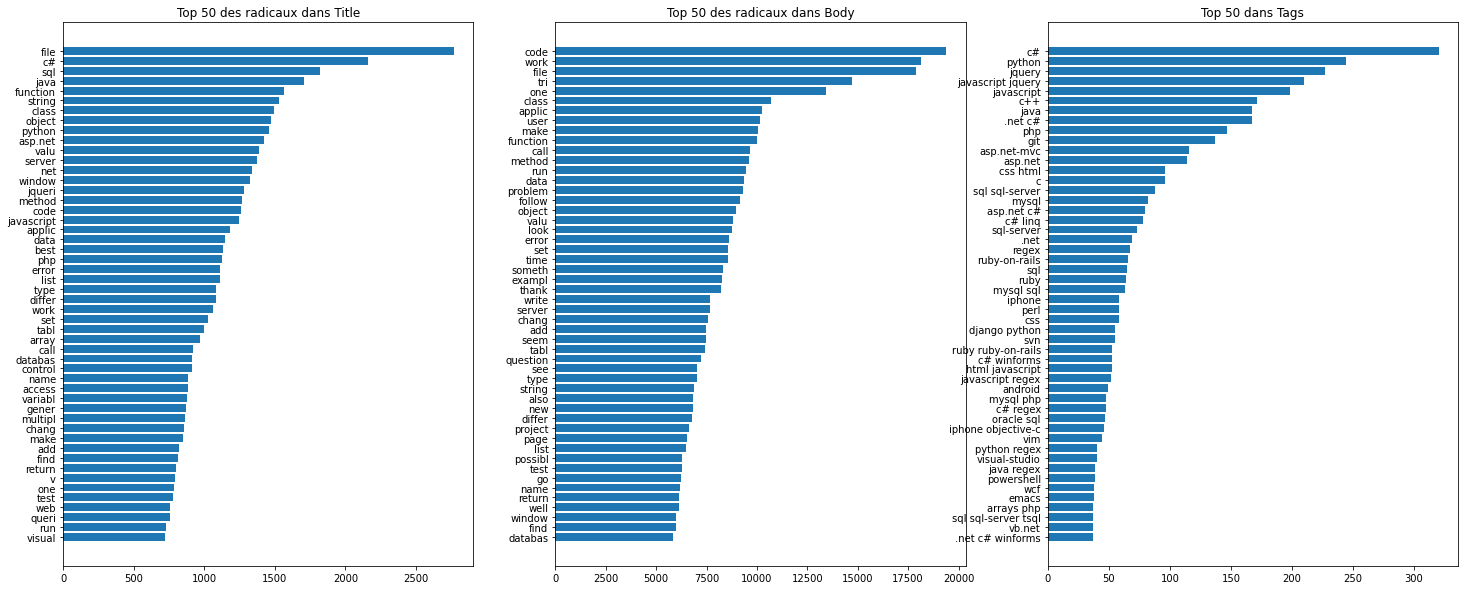

In [ ]:
cpt = 0 
fig = plt.figure(figsize=(25, 10))

for col in cols[:-1]:
    cpt += 1
    plt.subplot(1, 3, cpt)
    plt.barh([k for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des radicaux dans {}'.format(TOP, col))

temp = train.Tags.value_counts().to_frame('counts')
plt.subplot(133)
plt.barh(temp.sort_values(by='counts', ascending=True)[-TOP:].index, 
         temp.sort_values(by='counts', ascending=True)[-TOP:].counts)
plt.title('Top {} dans Tags'.format(TOP))

## Top Tags

Text(0.5, 1.0, 'Distribution du nombre de tags par question')

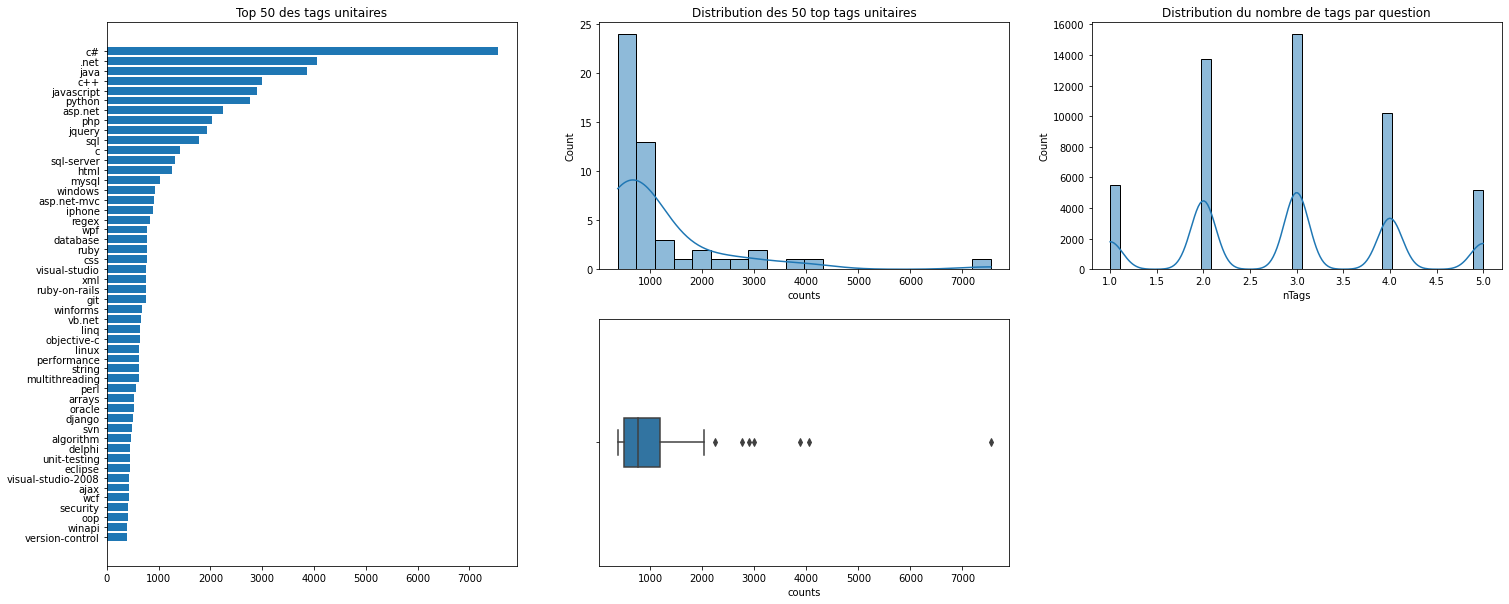

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.subplot(131)
plt.barh([k for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])])
plt.title('Top {} des tags unitaires'.format(TOP))

temp = pd.DataFrame.from_dict(dict(freq['Tags'][:TOP]), orient='index')\
                              .rename(columns={0:'counts'})
plt.subplot(232)
plt.title('Distribution des {} top tags unitaires'.format(TOP))
sns.histplot(temp.counts, kde=True)

plt.subplot(235)
sns.boxplot(x=temp.counts, width=0.2)

plt.subplot(233)
sns.histplot(train['nTags'], kde=True)
plt.title('Distribution du nombre de tags par question')

In [ ]:
pd.DataFrame(freq['Tags']).rename(columns={0:'Tag', 1:'count'}).describe()

,count
count,10494.000000
mean,13.895941
std,121.763098
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,7544.000000


In [ ]:
train['Tags_lbl'].value_counts().to_frame().describe()

,Tags_lbl
count,36891.000000
mean,1.355344
std,4.182327
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,320.000000


# Réduction du scope
Pour commencer, je considère les questions avec 1 seul tag 

In [ ]:
train_1T = train[train.nTags == 1]
freq = recap_cols(train_1T, cols)
print(train.shape)
train_1T.head()

Dénombrenent des mots
	Title  :   27305 dont   4294 distincts
	Body   :  190373 dont  13091 distincts
	Tags   :    5512 dont    867 distincts
(50000, 5)


,Title,Body,Tags,nTags,Tags_lbl
14646,add project descript fogbugz,new project even edit sampl project add descri...,fogbugz,1,26437
34017938,decrement valu scheme,procedur find small prime larg add paramet pro...,scheme,1,35715
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1,36655
2177008,mean rubi,mean rubi,ruby,1,35572
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c# net error...,.net,1,32


Réduction aux 50 top tags

Dénombrenent des mots
	Title  :   17219 dont   2865 distincts
	Body   :  114415 dont   9137 distincts
	Tags   :    3481 dont     50 distincts


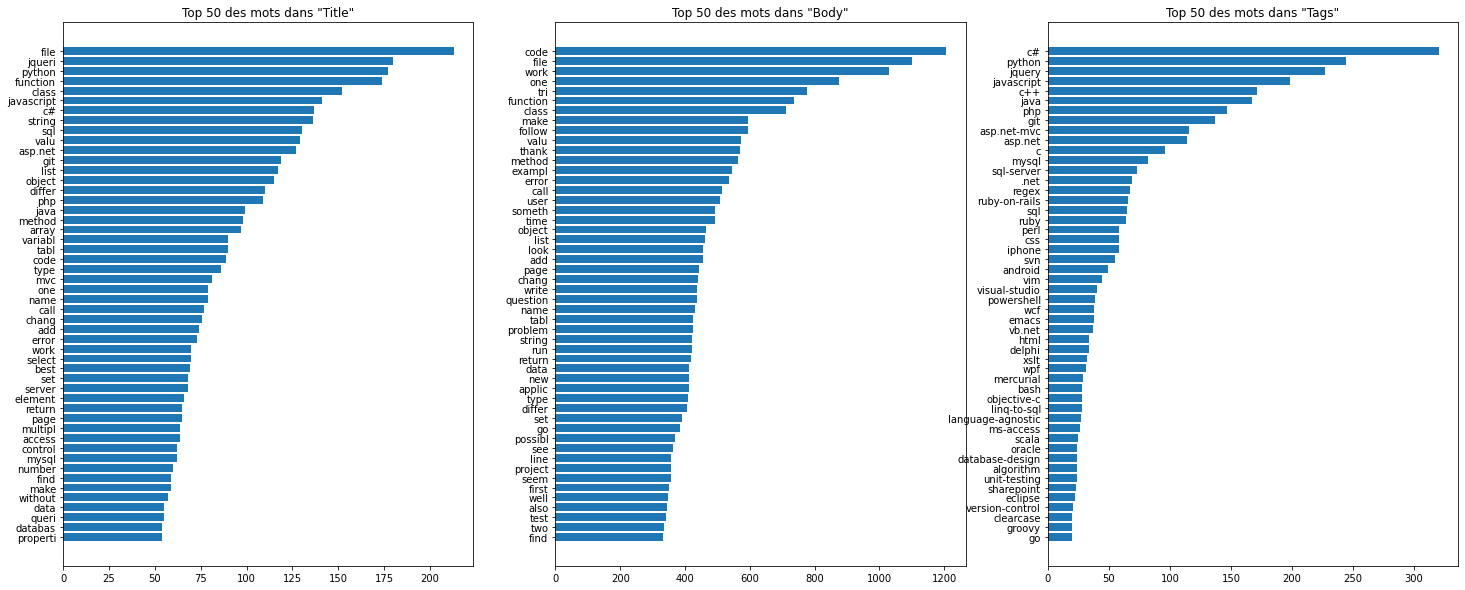

In [ ]:
top = 50

cpt = 1
train_1T = train_1T[train_1T.Tags.isin(dict(freq['Tags'][:top]).keys())]

freq = recap_cols(train_1T, cols)

fig = plt.figure(1, figsize=(25, 10))

for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:top], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:top], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(top, col))
    cpt += 1 

# Export

In [ ]:
with open('OC_DS_P6_backup.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL) 
    pickler.dump(train)